# Feature Selection
This section focuses on selecting the most relevant features for modeling wine quality. It involves analyzing the relationships between various features and identifying the most significant ones.

In [1]:
%%capture
%run 03_clean_data.ipynb

## 1. Understand the relationship between features using clustermap

Exploring feature relationships is critical for effective feature selection. We use clustermaps and heatmaps to visualize the relationships between features and the wine quality score.

### Comments about clustermap:
- Our model's performance is influenced by the considerable multicollinearity observed in the data. Identifying features with minimal correlation is essential. 
- To achieve this, we compare different feature lists, selecting one from closely correlated pairs for model evaluation. Each model is restricted to a maximum of 8 features. This approach aims to uncover independent and meaningful predictors for the development of an optimal model.

In [2]:
def create_corr_matrix(wine_type_df):
    """
    Create and return the correlation matrix for the numeric columns in the given df.

    Parameters:
    - wine_type_df (pandas.DataFrame): DataFrame that we want to do matrix on

    Returns:
    The correlation matrix for the numeric columns
    """
    numeric_columns = check_numeric_columns(wine_type_df)
    return wine_type_df[numeric_columns].corr()


def create_clustermap(wine_type_df, folder):
    """
    Create and display a clustermap of the correlation matrix for the df.

    Parameters:
    - wine_type_df (pandas.DataFrame): The DataFrame that we want to display clustermap
    """
    # create the correlation matrix
    correlation_matrix = create_corr_matrix(wine_type_df)
    
    # calculate p-values for each correlation coefficient
    pvalues = correlation_matrix.apply(lambda x: 
                                       correlation_matrix.columns.map(lambda y: 
                                                                      pearsonr(wine_type_df[x.name], wine_type_df[y])[1]))
    
    # create the mask for non-significant correlations (p-value > 0.05)
    mask_significant = pvalues > 0.05
    
    # create and display the clustermap
    g = sns.clustermap(correlation_matrix, 
                       mask=mask_significant, annot=True, 
                       cmap='seismic', 
                       row_cluster=True, 
                       col_cluster=True,
                       linewidths=.5, vmax=1, vmin=-1, annot_kws={'size': 10},
                       figsize=(12, 12))
    
    # hide column dendrogram
    g.ax_col_dendrogram.set_visible(False)
    
    # descrption
    title=f'Correlation Matrix Clustermap for {get_wine_str(wine_type_df)}'
    g.fig.suptitle(title, fontsize=20, weight='bold' , y=0.85)
    plt.setp(g.ax_heatmap.get_xticklabels(), fontsize=12, rotation=45, ha='right')
    plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=12)
    g.ax_cbar.set_position((1, .2,.03, .4))
    
    # save
    
    plt.savefig(f'../figures/{folder}/{title}.png', bbox_inches = 'tight')
    plt.show()


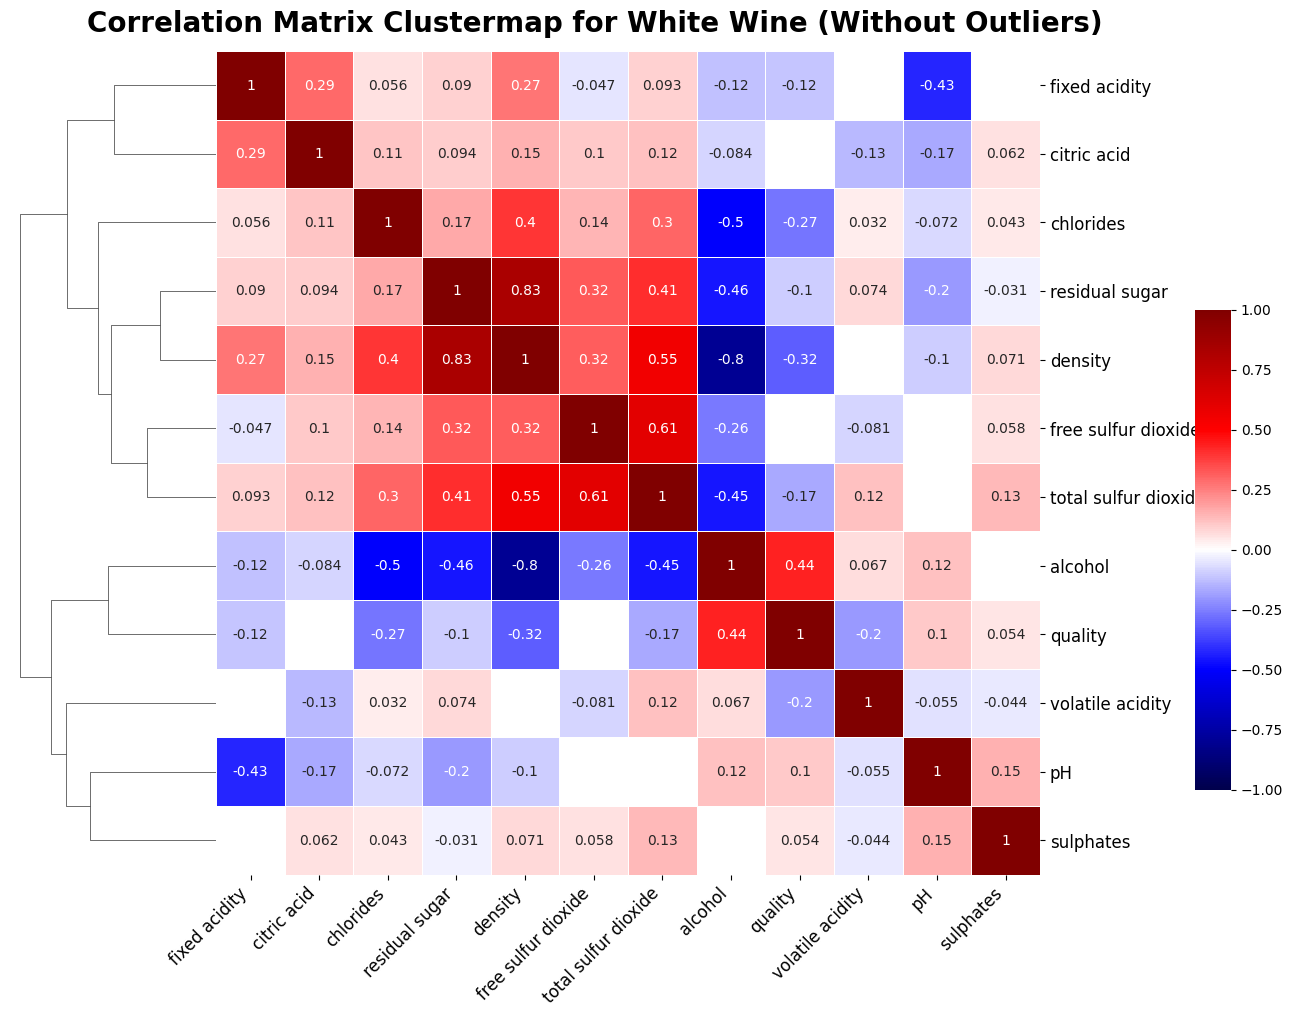

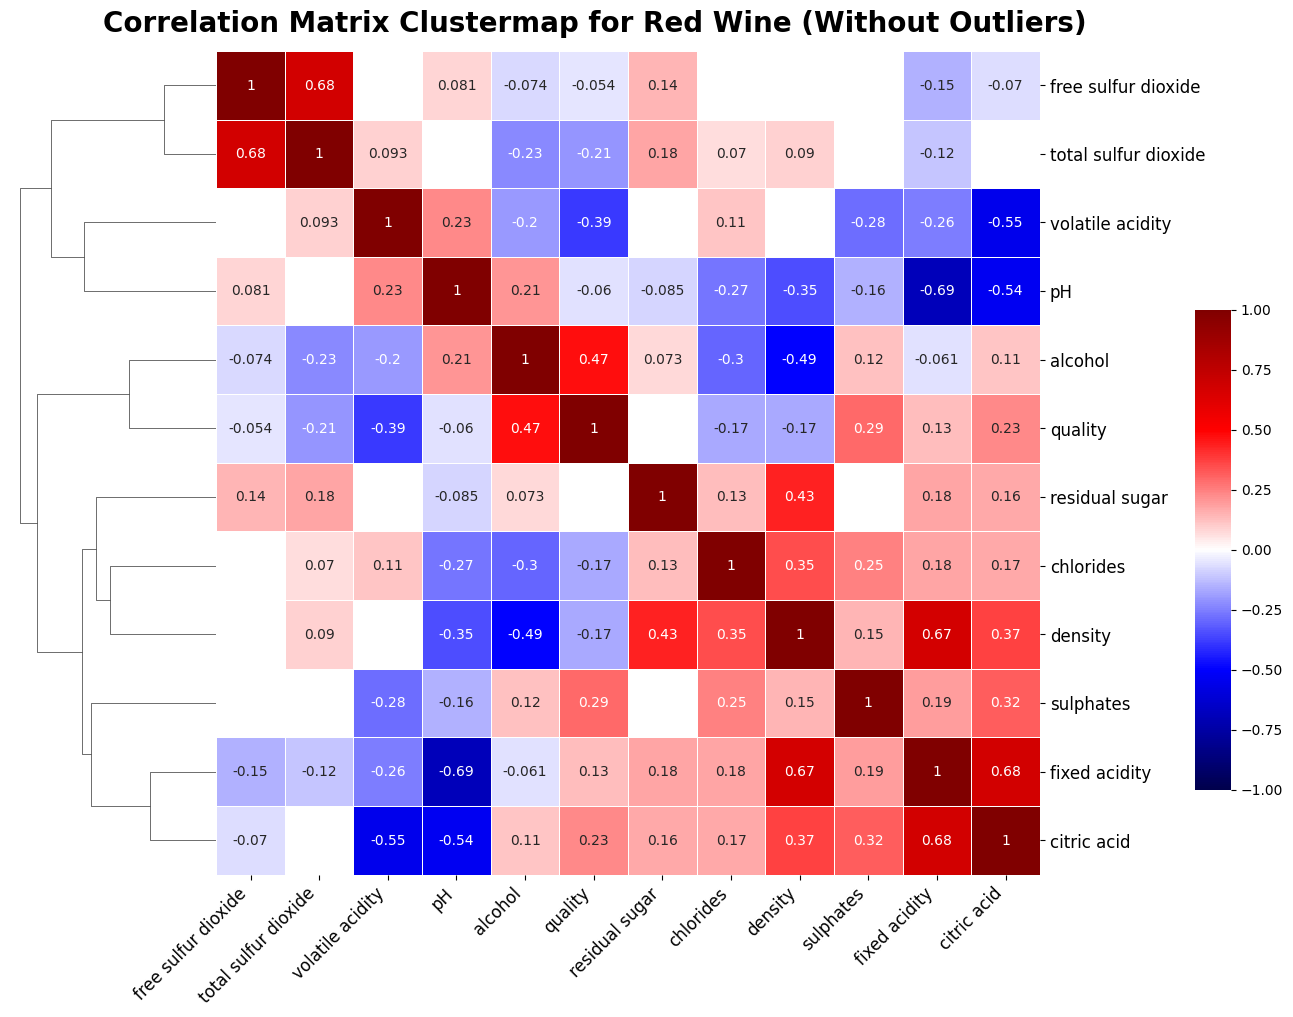

In [3]:
create_plots(create_clustermap, '1_Clustermaps_wine_type', wine_without_outliers_dfs)

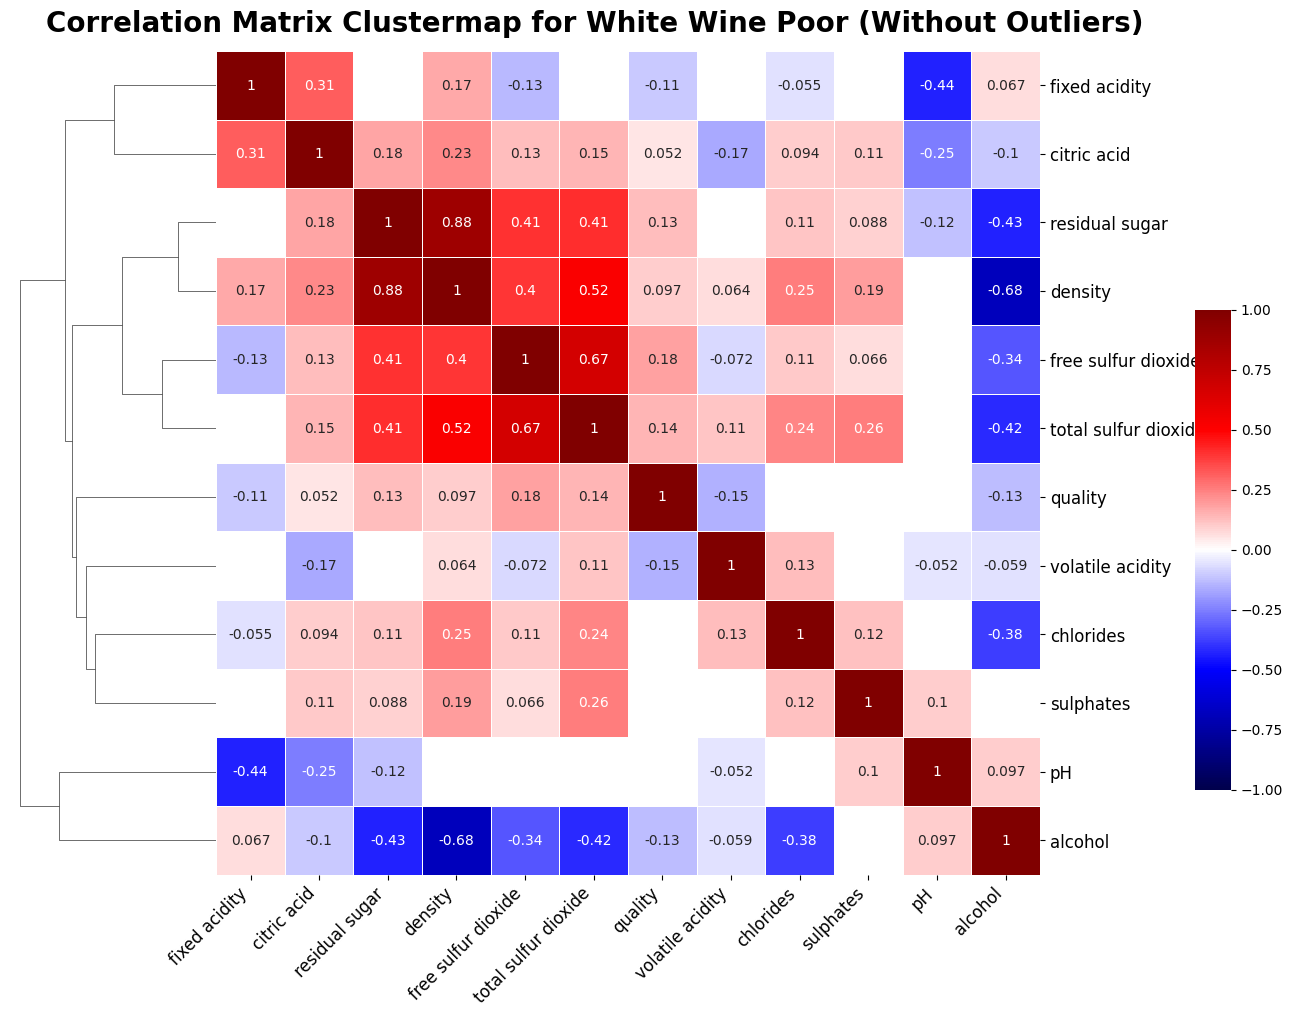

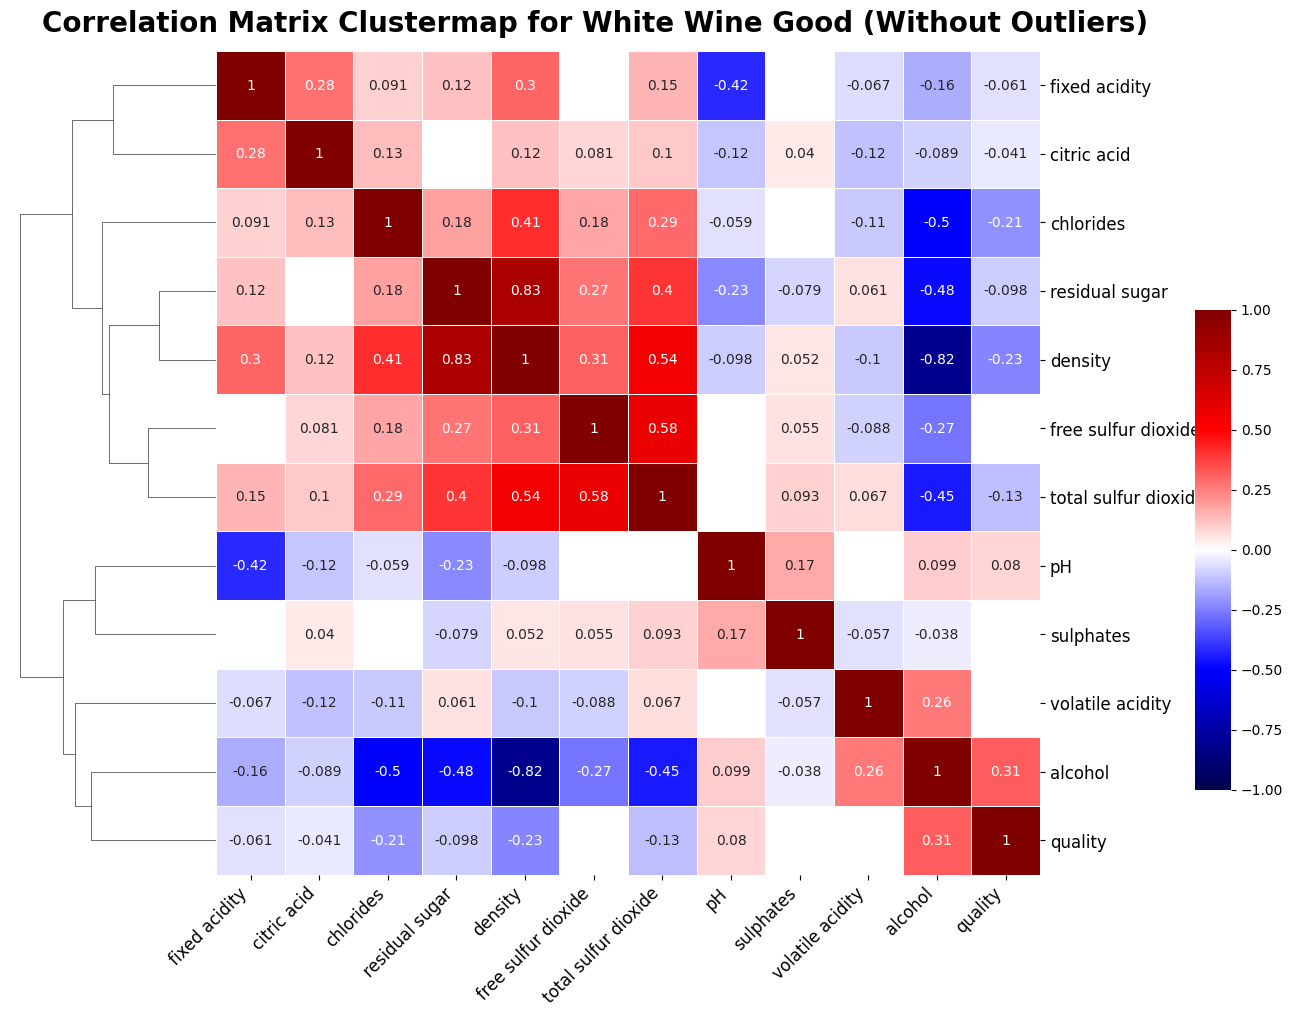

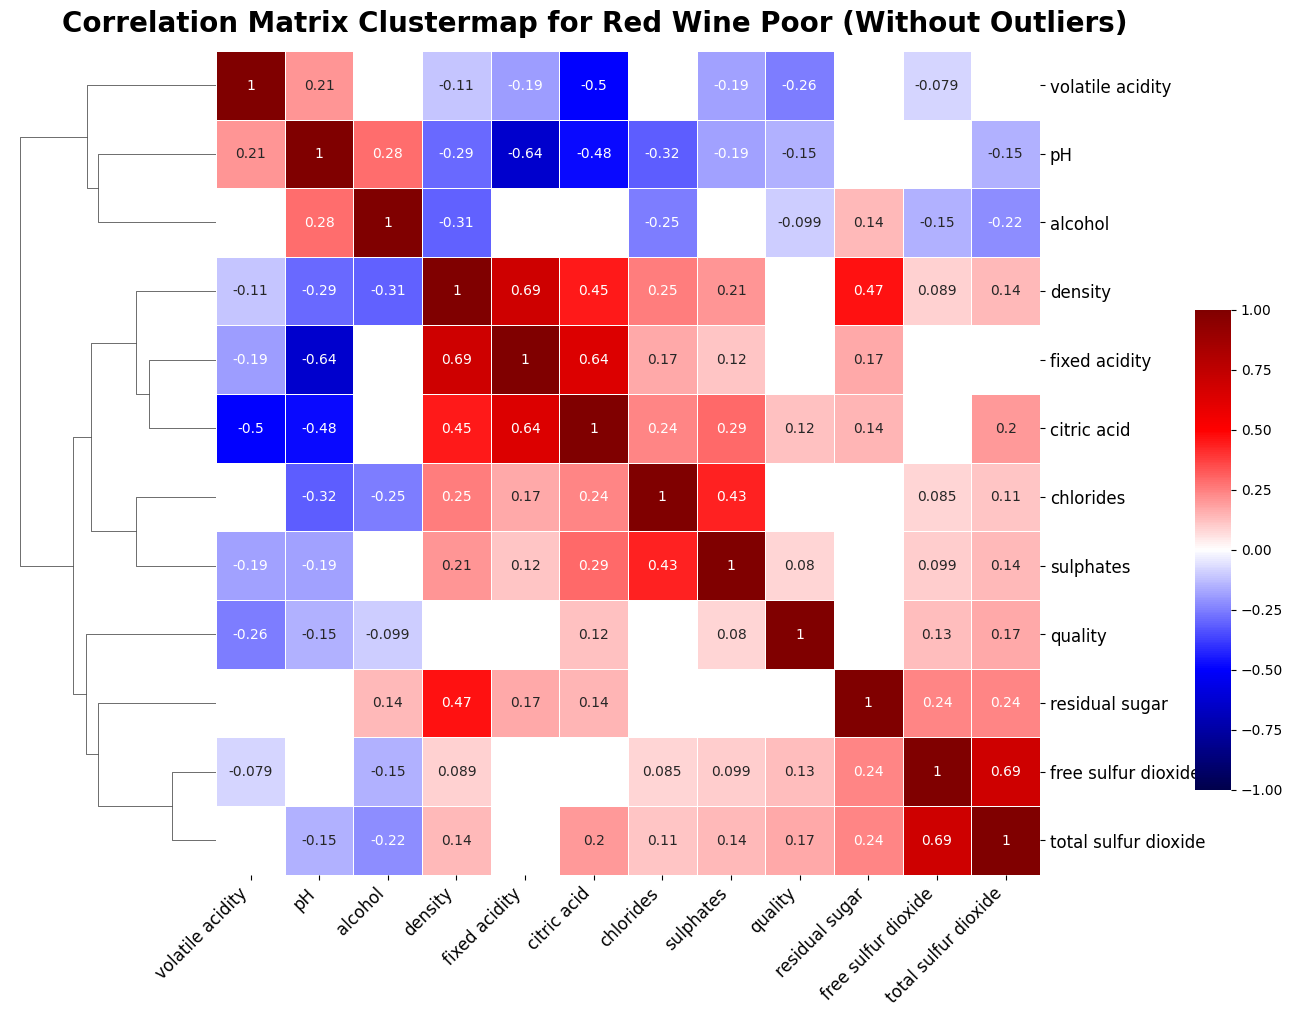

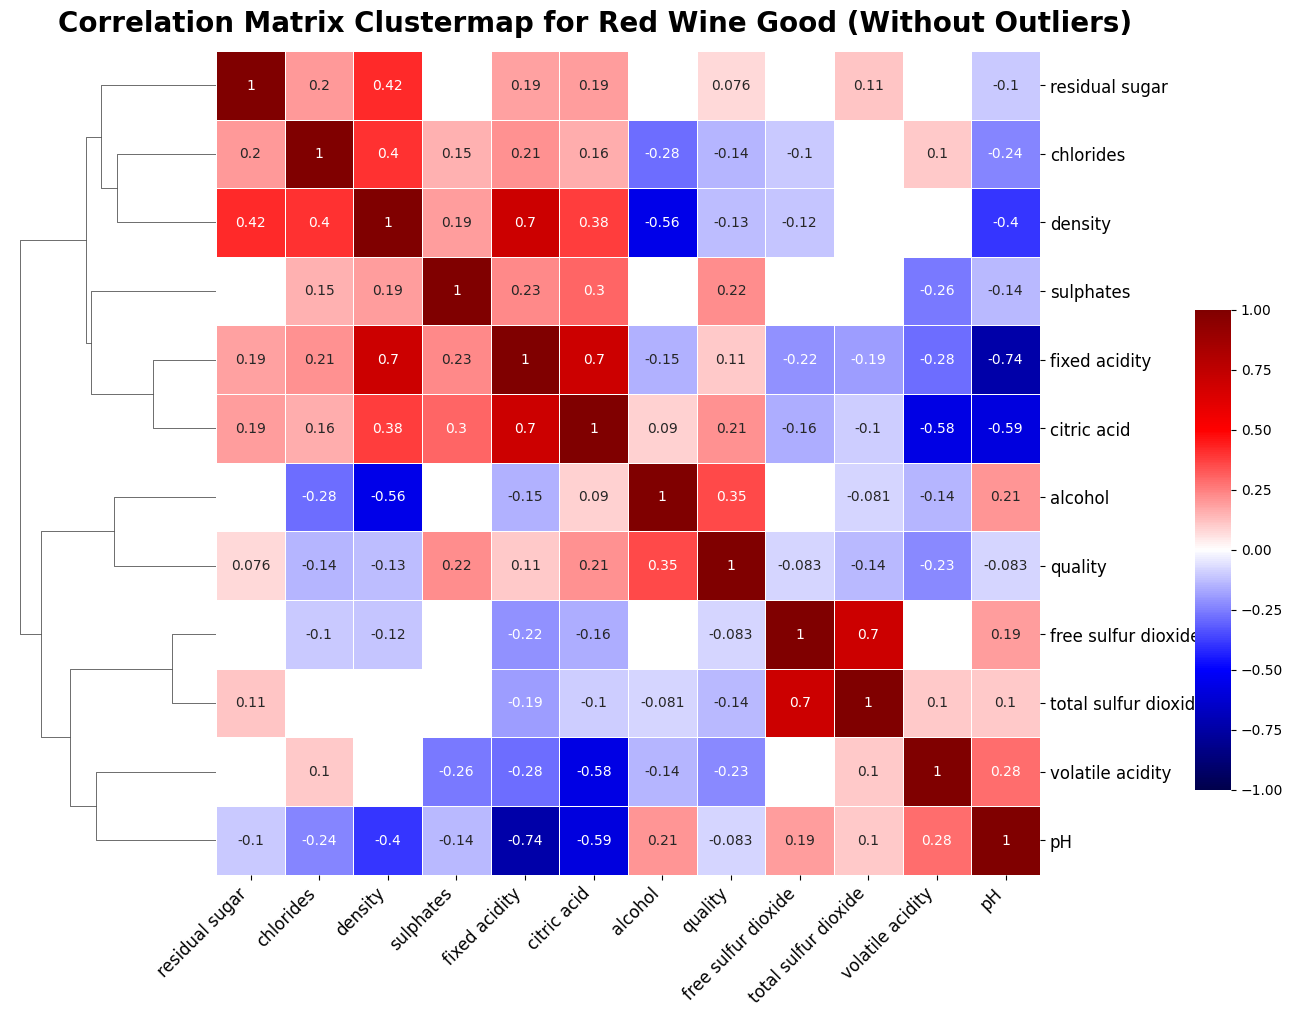

In [4]:
create_plots(create_clustermap, '2_Clustermaps_quality_without_outliers', wine_quality_without_outliers_dfs)

## 2. Creating features lists for models to find the best combination

The goal here is to compile lists of potential features to be used in model building. These lists will help us determine the best combination of features for predicting wine quality.

In [5]:
def create_corr_with_target(wine_type_df, target = 'quality'):
    '''
    This function calculates the correlation of each feature with the target variable, sorting them by their significance.
    '''
    correlation_matrix = create_corr_matrix(wine_type_df)
    correlation_with_target = correlation_matrix[target].sort_values(key=abs, ascending=False)

    return correlation_with_target


def return_top_features_with_target(wine_type_df, n = 8):
    '''
    This function returns top features that are related to the target column.
    '''
    correlation_with_target = create_corr_with_target(wine_type_df)

    top_features = correlation_with_target[1:n+1].index.tolist() 
    return top_features

In [6]:
def return_features_among_highly_associated(wine_type_df, threshold = 0.6, n =8 ):
    '''
    This function selects features that are less correlated with each other, based on a specified correlation threshold.
    '''
    correlation_matrix = create_corr_matrix(wine_type_df)
    correlation_with_target = create_corr_with_target(wine_type_df)
    #print(get_wine_str(wine_type_df))
    # print(correlation_matrix)
    #print(correlation_with_target)

    selected_features = [correlation_with_target.index[1]]  


    for feature in correlation_with_target.index[2:]:
        if all(abs(correlation_matrix[feature][selected_feature]) < threshold for selected_feature in selected_features):
            selected_features.append(feature)
            if len(selected_features) == n: 
                break

    return selected_features

In [7]:
top_features_dict = {}
features_among_highly_associated_dict = {}

def create_features_dict(df_lists):
    for wine_df in df_lists:
        try:
            df_name = get_wine_str(wine_df)
            top_features_dict[df_name] = return_top_features_with_target(wine_df)
            features_among_highly_associated_dict[df_name] = return_features_among_highly_associated(wine_df)
        except Exception as e:
            print(f"Error processing {df_name}: {e}")


In [13]:
create_features_dict(wine_quality_without_outliers_dfs)

In [14]:
create_features_dict(wine_without_outliers_dfs)
